In [1]:
using JLD
using PyPlot
using Statistics
using StatsBase 
using LinearAlgebra
using KernelDensity

In [2]:
using MultivariateStats

In [3]:
using JLD2
using FileIO

In [4]:
function linreg(x, y; bias_c=true)
    
	X = Array{Float64}(undef, length(x),1)
	Y = Vector{Float64}(undef, length(y))
	X[1:length(x),1] .= x
	Y[1:length(y)] .= y
	sol = llsq(X, Y)
	coeff, bias = sol[1], sol[2]
    
    if bias_c == true
        g1(x) = bias + coeff*x 
        return g1, (coeff, bias)
    end
    
    if bias_c == false
        g2(x) = coeff*x
        return g2, (coeff, bias)
    end
    
end

linreg (generic function with 1 method)

In [5]:
data = load("../data/experiment/images.jld")

Dict{String,Any} with 5 entries:
  "ImagesIS2"   => [0 0 … 0 0; 0 0 … 0 0; … ; 43 33 … 35 15; 23 140 … 44 28]…
  "ImagesBTV50" => [10 3 … 0 0; 3 0 … 0 0; … ; 6 0 … 0 0; 4 0 … 0 0]…
  "charge"      => [0.1298, 0.1712, 0.095, 0.0433, 0.097, 0.136, 0.1404, 0.1837…
  "ImagesBTV26" => [81 24 … 14 0; 70 49 … 37 0; … ; 38 54 … 23 3; 69 22 … 23 4]…
  "ImagesBTV53" => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 21 0; 0 0 … 0 0]…

In [6]:
cam_1 = data["ImagesBTV50"]
cam_2 = data["ImagesBTV53"]
cam_3  = data["ImagesBTV26"]
cam_4 = data["ImagesIS2"]
charge  = data["charge"]

enumerate_events = collect(1:length(charge));

In [7]:
cam_1_frame = (x=(160, 260), y=(140, 220))
cam_2_frame = (x=(140, 240), y=(100, 200))
cam_3_frame = (x=(200, 250), y=(140, 180))
cam_4_frame = (x=(500, 850), y=(360, 600));

# 1. Measurements with Small Charge: 

In [8]:
event_mask = findall(x-> 5 < x < 15, charge);

In [9]:
data_temp = cam_1

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c1  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(33165.11881307128, 26920.526907729978), (33165.11881307128, 26920.526907729978))

In [10]:
data_temp = cam_2

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c2  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(45464.11338665009, 11587.696504168856), (45464.11338665009, 11587.696504168856))

In [11]:
data_temp = cam_3

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c3  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(27521.913624961537, 4183.5798839761355), (27521.913624961537, 4183.5798839761355))

In [12]:
data_temp = cam_4

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c4  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(294501.8346643575, 91040.82639275688), (294501.8346643575, 91040.82639275688))

In [13]:
coeff_c1[1], coeff_c2[1], coeff_c3[1], coeff_c4[1]

(33165.11881307128, 45464.11338665009, 27521.913624961537, 294501.8346643575)

In [14]:
# FileIO.save("../data/experiment/m1/light_intensity-1.jld2", 
#     Dict("cam_1" => coeff_c1[1], 
#         "cam_2" => coeff_c2[1], 
#         "cam_3" => coeff_c3[1], 
#         "cam_4" => coeff_c4[1]))

# 2. Measurements with Large Charge: 

In [15]:
event_mask = findall(x-> x > 15, charge);

In [16]:
data_temp = cam_1

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c1  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(34896.56036321328, -13542.150346379916), (34896.56036321328, -13542.150346379916))

In [17]:
data_temp = cam_2

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c2  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(50315.11348329458, -55316.69234661002), (50315.11348329458, -55316.69234661002))

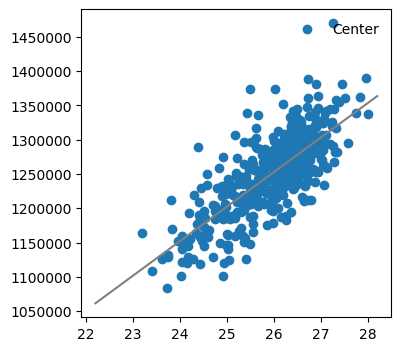

PyObject <matplotlib.legend.Legend object at 0x7fde71317c90>

In [18]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(charge_tmp, light_center, label="Center")

xx = minimum(charge_tmp)-1:maximum(charge_tmp)+1
ax.plot(xx, lin_int.(xx), color="gray")

ax.legend(loc="upper right", ncol=3, framealpha=0.0)

In [19]:
data_temp = cam_3

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c3  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(10317.860437330588, 8887.506761805962), (10317.860437330588, 8887.506761805962))

In [20]:
data_temp = cam_4

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c4  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(310986.9976752911, 485597.88556666416), (310986.9976752911, 485597.88556666416))

In [21]:
coeff_c1[1], coeff_c2[1], coeff_c3[1], coeff_c4[1]

(34896.56036321328, 50315.11348329458, 10317.860437330588, 310986.9976752911)

In [22]:
# FileIO.save("../data/experiment/m2/light_intensity-2.jld2", 
#     Dict("cam_1" => coeff_c1[1], 
#         "cam_2" => coeff_c2[1], 
#         "cam_3" => coeff_c3[1], 
#         "cam_4" => coeff_c4[1]))